In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import pylab as plt
plt.style.use('fivethirtyeight')

# Read data

In [2]:
data = pd.read_csv('./data/EF_battles_corrected2.csv', parse_dates=['start', 'end'])

### Data types and missing values

In [3]:
data.dtypes

name                                     object
allies casualties                        object
axis casualties                          object
url                                      object
allies killed                           float64
axis killed                             float64
allies tanks                              int64
allies airplane                           int64
allies guns                               int64
axis tanks                                int64
axis airplane                             int64
axis guns                                 int64
axis ships                                int64
axis submarines                           int64
Belligerents.allies                      object
Belligerents.axis                        object
Commanders and leaders.allies            object
Commanders and leaders.axis              object
Date                                     object
Location                                 object
Result                                  

In [23]:
cols = [
    'allies killed', 'allies tanks', 'allies guns','allies airplane',
    'axis killed', 'axis tanks', 'axis guns', 'axis airplane',
    'period'
]

In [24]:
data['period'] = (data['end'].dt.year*12 + data['end'].dt.month) - (data['start'].dt.year*12 + data['start'].dt.month) + 1
data['period'].fillna(1, inplace=True)

In [25]:
# data['result']

In [26]:
mask = data[cols].isnull().any(1)
data_kmeans = data.loc[~mask, cols]

# 1. Unsupervised learning: K-means

In [27]:
from sklearn.cluster import KMeans

In [28]:
model = KMeans(n_clusters=3)

In [29]:
labels = model.fit_predict(data_kmeans)

In [30]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 0 0 0 0 2 0 1 0 0 0
 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


In [31]:
data.loc[~mask, 'label'] = labels

## Visualise

In [32]:
import altair as alt
alt.renderers.enable('notebook')


RendererRegistry.enable('notebook')

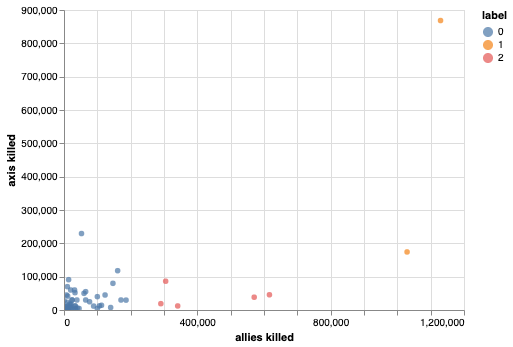

In [33]:
alt.Chart(data).mark_circle().encode(
    color='label:N',
    x='allies killed', y='axis killed',
    tooltip=['name', 'start', 'result'] + cols).interactive()

# Scale

In [91]:
from sklearn.preprocessing import scale

In [92]:
data_scaled = scale(data_kmeans)

In [37]:
labels_scaled = model.fit_predict(data_scaled)

In [38]:
data.loc[~mask, 'label2'] = labels_scaled

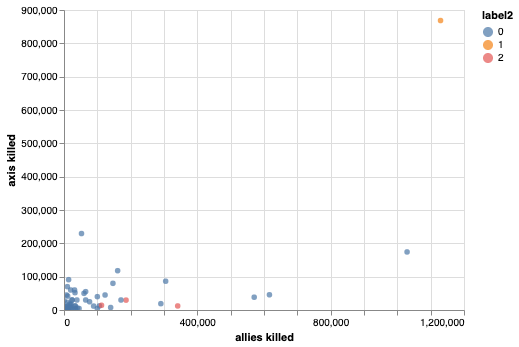

In [39]:
alt.Chart(data).mark_circle().encode(
    color='label2:N',
    x='allies killed', y='axis killed',
    tooltip=['name', 'start', 'result'] + cols).interactive()

In [40]:
df_scaled = pd.DataFrame(data_scaled, index=data_kmeans.index, columns=data_kmeans.columns)
df_scaled['label'] = labels_scaled

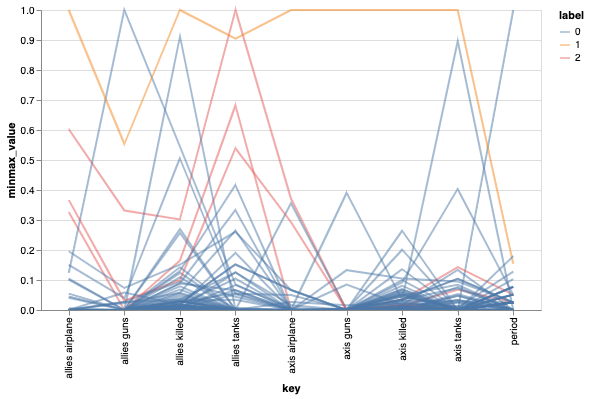

In [41]:

alt.Chart(df_scaled).transform_window(
    index='count()'
).transform_fold(
    cols
).transform_joinaggregate(
     min='min(value)',
     max='max(value)',
     groupby=['key']
).transform_calculate(
    minmax_value=(alt.datum.value-alt.datum.min)/(alt.datum.max-alt.datum.min),
    mid=(alt.datum.min+alt.datum.max)/2
).mark_line().encode(
    x='key:N',
    y='minmax_value:Q',
    color='label:N',
    detail='index:N',
    opacity=alt.value(0.5)
).properties(width=500)

# 2. Supervised Learning: Decision trees

In [42]:
data['result_num'] = data['result'].map({'axis':-1, 'allies':1}).fillna(0) # * data['result_prop']

In [43]:
data['result_num'].value_counts()

-1.0    93
 1.0    34
 0.0     6
Name: result_num, dtype: int64

In [44]:
from sklearn.model_selection import train_test_split

In [136]:
Xs = scale(data.loc[~mask, cols])

In [137]:
# ?train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xs, 
                                                data.loc[~mask, 'result_num'], 
                                                test_size=0.2, random_state=2019)


In [138]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [139]:
model = KNeighborsClassifier(n_neighbors=5)

In [140]:
model.fit(Xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [141]:
from sklearn.metrics import accuracy_score, classification_report

In [142]:
ypred1 = model.predict(Xtest)

In [143]:
print(classification_report(ytest, ypred1))

              precision    recall  f1-score   support

        -1.0       0.71      1.00      0.83        12
         0.0       0.00      0.00      0.00         1
         1.0       0.00      0.00      0.00         4

    accuracy                           0.71        17
   macro avg       0.24      0.33      0.28        17
weighted avg       0.50      0.71      0.58        17



/Users/philippk/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [146]:
ytest

108   -1.0
126    1.0
81    -1.0
10    -1.0
112   -1.0
4     -1.0
115   -1.0
0     -1.0
24    -1.0
61    -1.0
73     1.0
85    -1.0
67     0.0
52    -1.0
25    -1.0
98     1.0
17     1.0
Name: result_num, dtype: float64

In [149]:
(ypred1 != -1).any()

False

In [145]:
accuracy_score(ytest, ypred1)

0.7058823529411765